In [1]:
import sys
import numpy as np
import pandas as pd
sys.path.append('/Volumes/Lab/Users/bhofflic/cell_classification/src/')
import cell_display_lib as cdl
from tqdm import tqdm
from matplotlib import pyplot as plt
from src.classification.classification import tc_params, tc_warp

scratch_file_root = '/Volumes/Scratch/Users/bhofflic/celltable_runs' # replace my name!
corr_analysis_path = '/Volumes/Scratch/Users/bhofflic/cell_correlations/'

pieces = [
    # '2005-04-14-0', #9.8*
    # '2005-04-26-1', #20.7*
    # '2005-07-07-2', #7.8*
    # '2015-09-23-7', #40.6*
    # '2016-02-17-1', #29.1*
    # '2016-02-17-6', #28.0*
    # '2016-02-17-8', #48.6*
    # '2016-04-21-1', #33.8*
    '2017-03-15-1', #21.1*
    # '2017-03-15-8', #12.3*
    # '2017-08-14-4', #14.3*
    # '2017-11-29-0', #33.0*
    # '2018-03-01-0', #98.3-
    # '2018-08-07-1', #26.1
    # '2018-08-07-11',#8.5*
    # '2018-08-07-2', #15.7*
    '2018-08-07-5', #22.2*
    # '2018-08-07-9', #13.9*
]

In [2]:
cts = {}

for piece_id in tqdm(pieces):
    ct = cdl.CellTable()
    ct.file_load_pieces(scratch_file_root, [piece_id])
    cts[piece_id] = ct

  0%|          | 0/2 [00:00<?, ?it/s]

~ Welcome to the CellTable ~experience~
~ 
~ Starting a fresh new CellTable
~ Loading 1 pieces from /Volumes/Scratch/Users/bhofflic/celltable_runs: ['2017-03-15-1']
*** timer  started
Loading piece 2017-03-15-1
~ Successfully loaded piece 2017-03-15-1
*** elapsed 118s of 118s = 2.0m elapsed, of 2.0m estimated (1/1) (0.0 / sec)
~ Processing labels (replace nan, update label encoder and unique names)
Copying cell labels to units
combined mode


 50%|█████     | 1/2 [01:58<01:58, 118.71s/it]

~ Done loading, time to analyze.
~ Welcome to the CellTable ~experience~
~ 
~ Starting a fresh new CellTable
~ Loading 1 pieces from /Volumes/Scratch/Users/bhofflic/celltable_runs: ['2018-08-07-5']
*** timer  started
Loading piece 2018-08-07-5
~ Successfully loaded piece 2018-08-07-5
*** elapsed 115s of 115s = 1.9m elapsed, of 1.9m estimated (1/1) (0.0 / sec)
~ Processing labels (replace nan, update label encoder and unique names)
Copying cell labels to units
combined mode


100%|██████████| 2/2 [03:54<00:00, 117.48s/it]

~ Done loading, time to analyze.


In [3]:
ct = cts[pieces[0]]

In [7]:
ct.unit_table.keys()

Index(['unit_id', 'dataset_id', 'run_id', 'piece_id', 'valid', 'cell_id',
       'label_manual_text', 'label_manual', 'label_manual_text_input',
       'label_manual_input', 'acf', 'sta', 'sta_bw', 'sta_signal_level',
       'sta_noise_level', 'sta_snr', 'sta_extremes', 'map_sta_peak',
       'map_sig_stixels', 'tc', 'tc_all', 'rf_center_x', 'rf_center_y',
       'map_rf', 'map_rf_bool', 'rf_noise_level', 'rf_threshold', 'rf_size',
       'rf_size_hull', 'rf_num_islands', 'rf_solidity', 'sta_edge',
       'rf_boundary', 'rf_convex_hull', 'hull_center_x', 'hull_center_y',
       'spike_times', 'spike_count', 'spike_duration', 'spike_rate_mean', 'ei',
       'spike_waveform_maxenergy', 'spike_waveform_maxamplitude',
       'spike_waveform_smart', 'ei_edge', 'ei_peak', 'ei_axon_only',
       'ei_energy_raw', 'map_ei_energy', 'map_ei_energy_early',
       'map_ei_energy_late'],
      dtype='object')

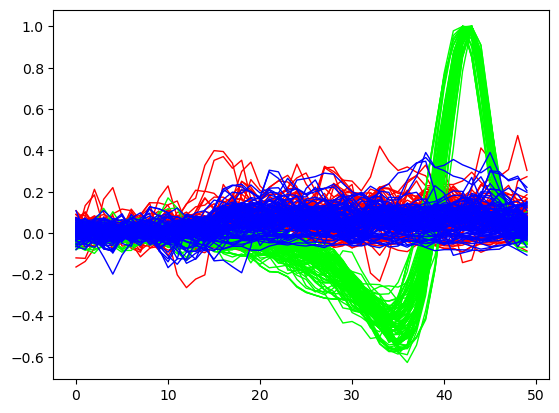

In [4]:
tcs = ct.unit_table.query("label_manual_text == 'ON parasol' and run_id == '000'").tc
tcs = np.array([tcs.iloc[i].a for i in range(len(tcs))])
for i in range(len(tcs)):
    tcs[i] /= np.max(np.abs(tcs[i]))
x_tc = np.linspace(-50/120,0,tcs.shape[1])
plt.plot(tcs[:,:,0].T, color='red', linewidth=1, alpha=1)
plt.plot(tcs[:,:,1].T, color='lime', linewidth=1, alpha=1)
plt.plot(tcs[:,:,2].T, color='blue', linewidth=1, alpha=1)

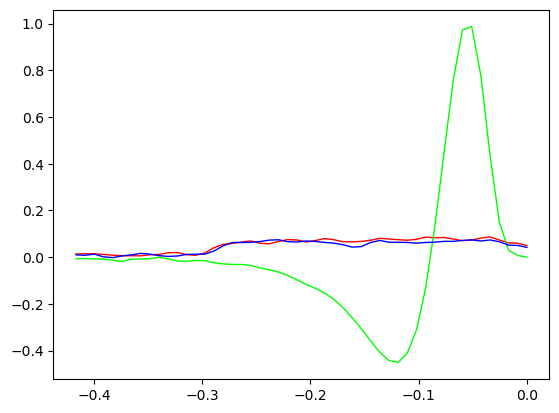

In [93]:
# Calculate zero crossing of average TC
tc_avg = np.mean(tcs, axis=0)
x_tc = np.linspace(-50/120,0,tcs.shape[1])
plt.plot(x_tc, tc_avg[:,0], color='red', linewidth=1, alpha=1)
plt.plot(x_tc, tc_avg[:,1], color='lime', linewidth=1, alpha=1)
plt.plot(x_tc, tc_avg[:,2], color='blue', linewidth=1, alpha=1)

In [12]:
def ct_zc(ct, ref_type):
    tcs = ct.unit_table.query("label_manual_text == @ref_type and run_id == '000'").tc
    tcs = np.array([tcs.iloc[i].a for i in range(len(tcs))])
    for i in range(len(tcs)):
        tcs[i] /= np.max(np.abs(tcs[i]))
    ref_avg = np.mean(tcs, axis=0)
    return tc_params(ref_avg[:,1])[0]
ref_zcs = {
    'ON': ct_zc(list(cts.values())[0], 'ON parasol'),
    'OFF': ct_zc(list(cts.values())[0], 'OFF parasol'),
}

dataset_zcs = {}
dataset_scales = {}
for piece_id in tqdm(pieces):
    ct = cts[piece_id]
    dataset_zcs[piece_id] = {
        'ON': ct_zc(ct, 'ON parasol'),
        'OFF': ct_zc(ct, 'OFF parasol'),
    }
    dataset_scales[piece_id] = {
        'ON': np.abs(1/ref_zcs['ON']),
        'OFF': np.abs(1/ref_zcs['OFF'])
    }

ctypes = ['ON parasol', 'ON midget', 'ON smooth', 'OFF parasol', 'OFF midget', 'OFF smooth']
x_tc = np.linspace(-50/120, 0, 50)
normalized_tcs = []
all_cell_types = []
piece_ids = []
all_cell_sizes = []
for piece_id in tqdm(pieces):
    ct = cts[piece_id]
    cells = ct.unit_table.query("label_manual_text in @ctypes and run_id == '000'")
    tcs = cells.tc_all
    tcs = np.array([tcs.iloc[i].a for i in range(len(tcs))])
    cell_sizes = cells.rf_size
    cell_sizes = np.array([cell_sizes.iloc[i].a for i in range(len(tcs))])
    cell_sizes = np.sqrt(np.max(cell_sizes,axis=1)/np.pi)
    cell_types = np.array(cells.label_manual_text)
    zeroed_tcs = np.zeros(tcs.shape[0:2])
    for i in range(len(tcs)):
        if 'ON' in cell_types[i]:
            zeroed_tcs[i] = tc_warp(tcs[i,:,1], x_tc, zc_scale = dataset_scales[piece_id]['ON'])
        elif 'OFF' in cell_types[i]:
            zeroed_tcs[i] = tc_warp(tcs[i,:,1], x_tc, zc_scale = dataset_scales[piece_id]['OFF'])
        zeroed_tcs[i] /= np.max(np.abs(zeroed_tcs[i]))
    normalized_tcs.append(zeroed_tcs)
    all_cell_types.append(cell_types)
    all_cell_sizes.append(cell_sizes)
    piece_ids.append(np.repeat(piece_id, len(cell_types)))
    
normalized_tcs = np.concatenate(normalized_tcs, axis=0)
all_cell_types = np.concatenate(all_cell_types, axis=0)
all_cell_sizes = np.concatenate(all_cell_sizes, axis=0)
piece_ids = np.concatenate(piece_ids, axis=0)




  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 13.67it/s]


/Volumes/Lab/Development/miniconda-peggyo/envs/bhofflich-scpy/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Volumes/Lab/Development/miniconda-peggyo/envs/bhofflich-scpy/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 932 samples in 0.000s...
[t-SNE] Computed neighbors for 932 samples in 0.095s...
[t-SNE] Computed conditional probabilities for sample 932 / 932
[t-SNE] Mean sigma: 0.480062
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.619766
[t-SNE] KL divergence after 300 iterations: 0.728695


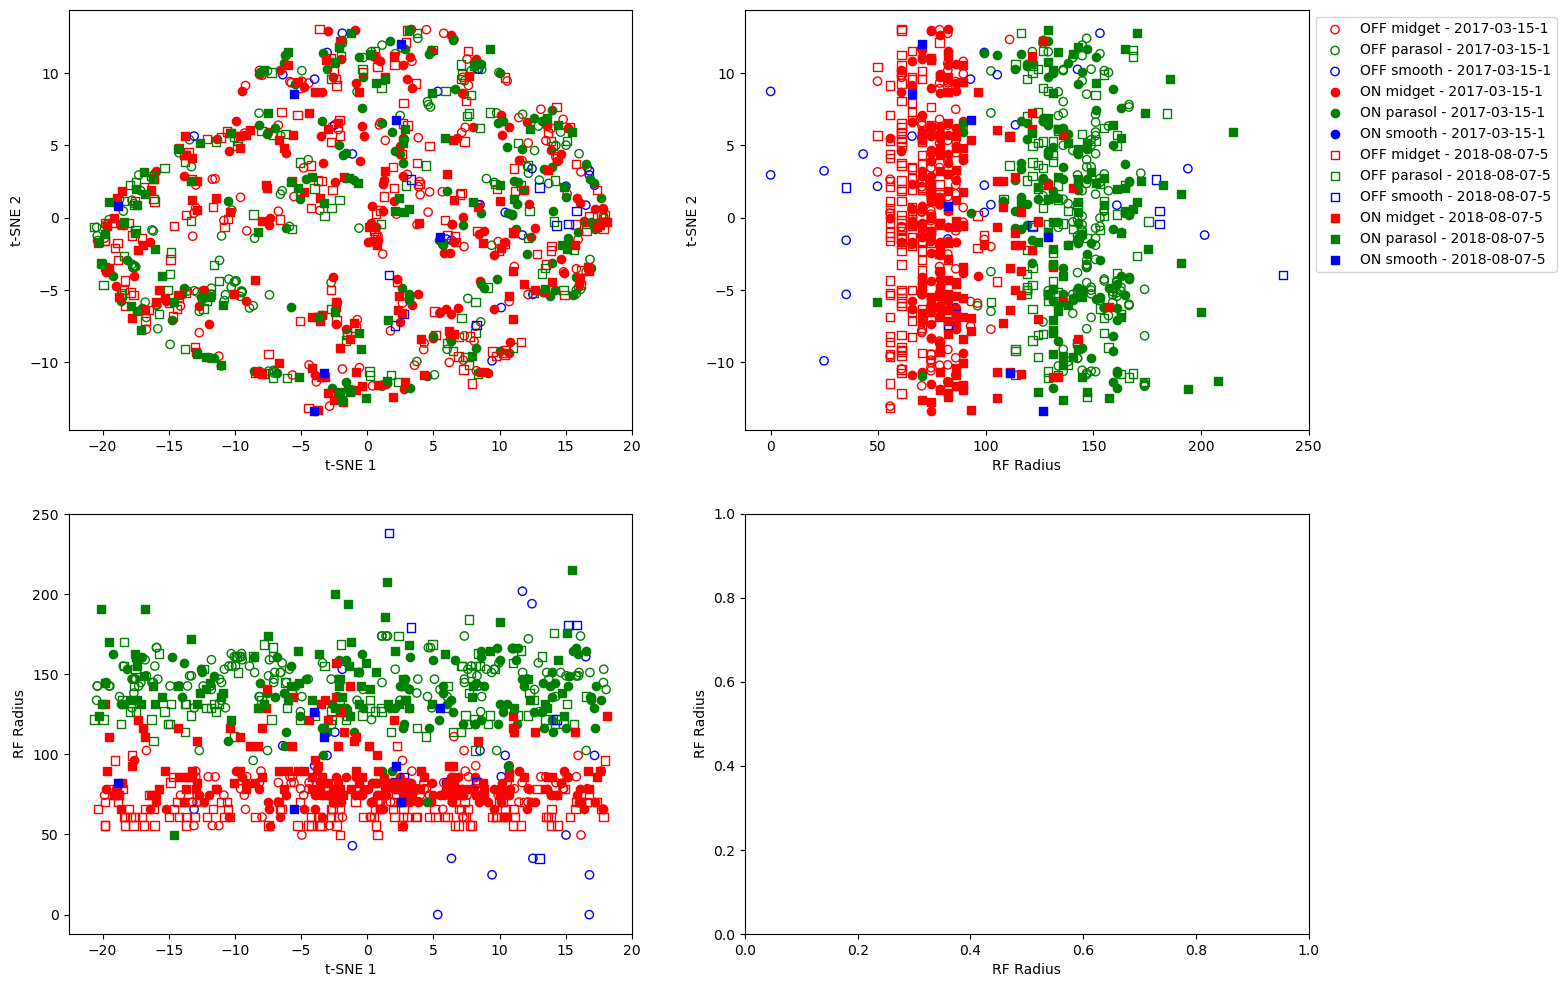

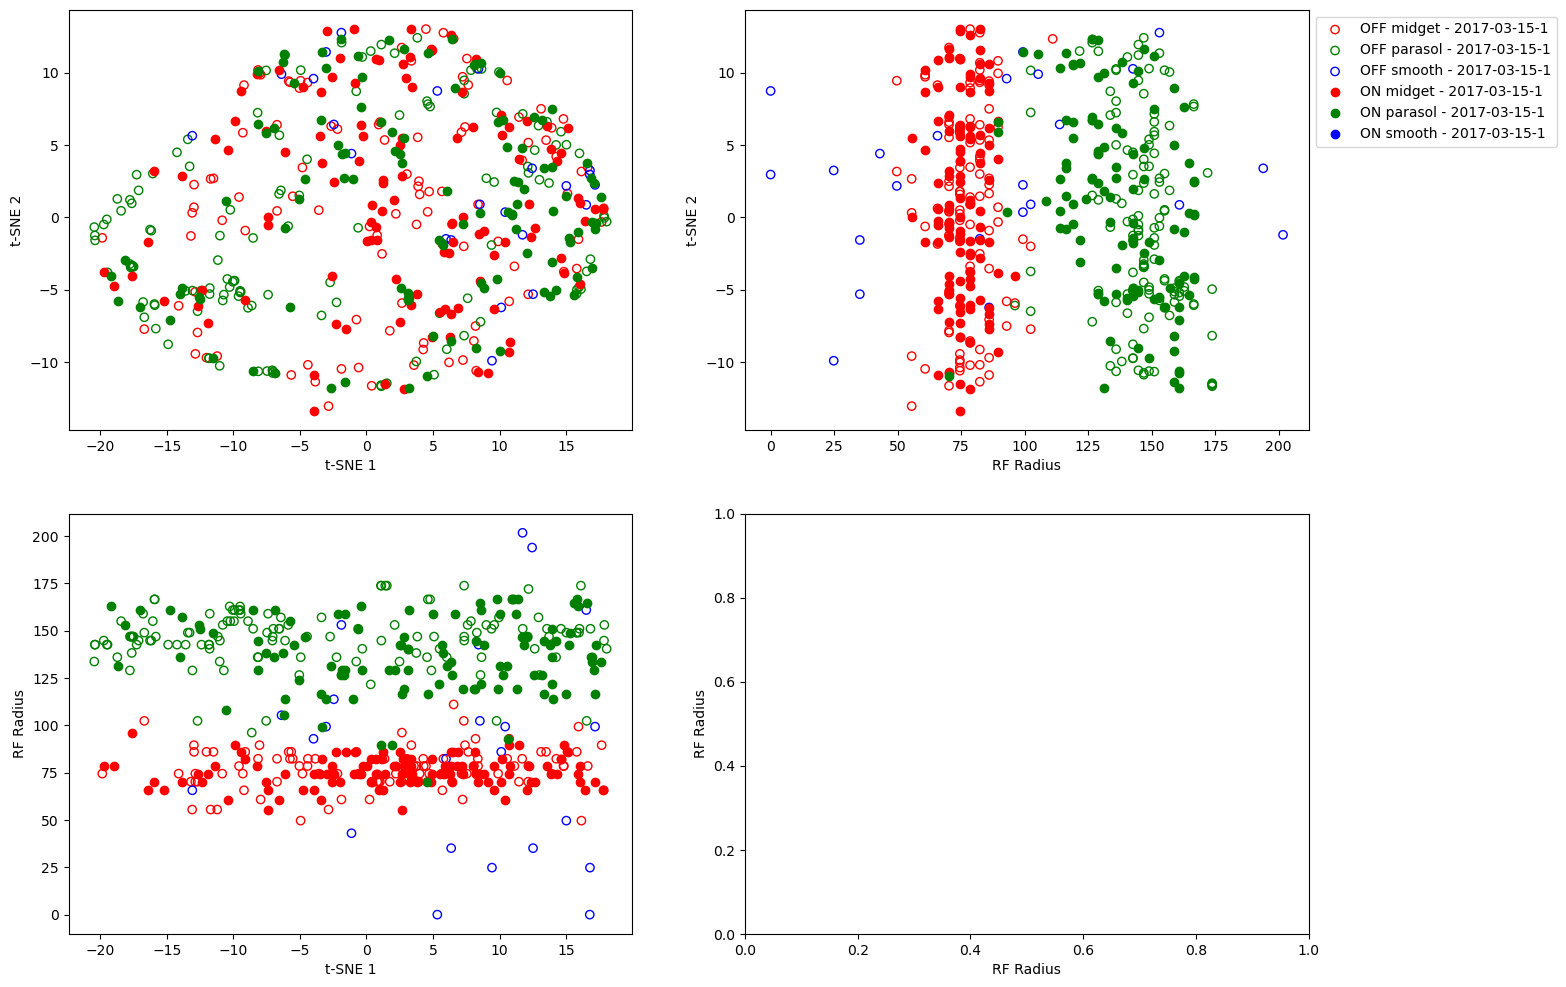

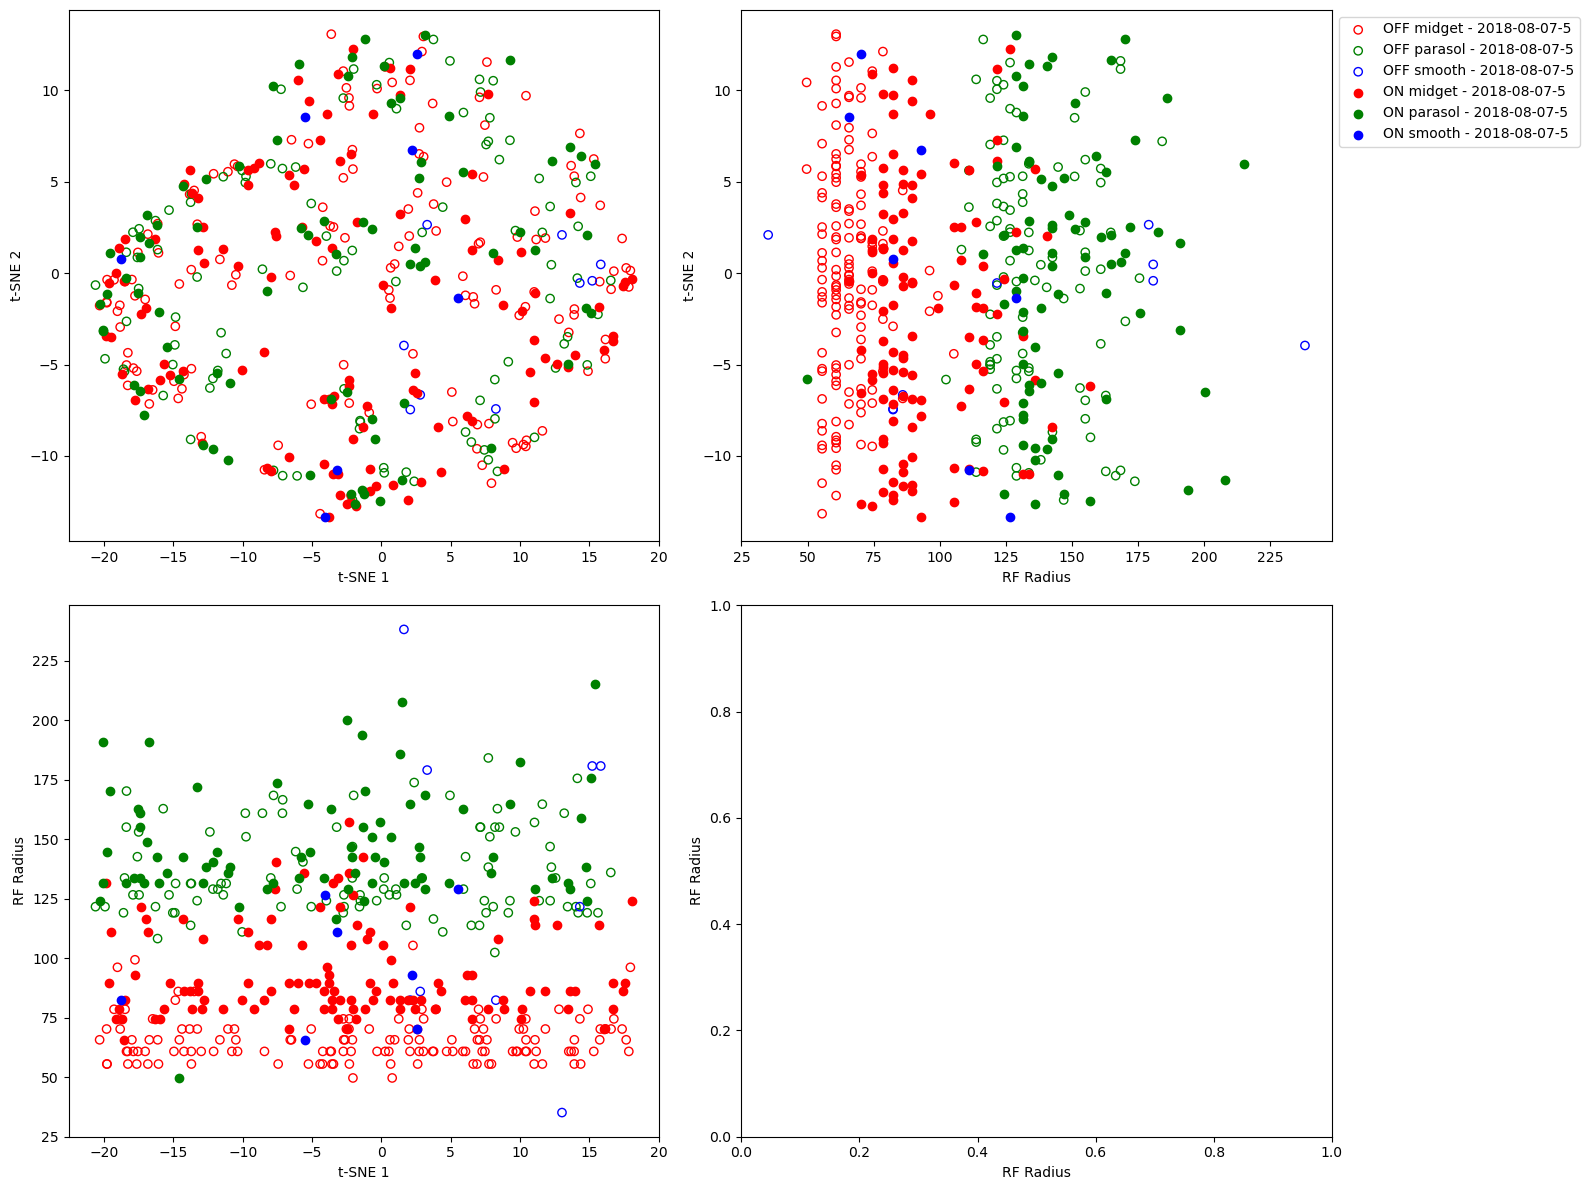

In [31]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=50)  # Adjust n_components based on your needs
pca_result = pca.fit_transform(normalized_tcs)

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result)

colors = {
    'ON parasol': 'green',
    'ON midget': 'red',
    'ON smooth': 'blue',
    'OFF parasol': 'green',
    'OFF midget': 'red',
    'OFF smooth': 'blue',
}
markers = ['o', 's']
fig, axs = plt.subplots(2,2,figsize=(16,12))
for j, piece in enumerate(pieces):
    fig, axs1 = plt.subplots(2,2,figsize=(16,12))
    for cell_type in np.unique(all_cell_types):
        label = f"{cell_type} - {piece}"
        indices = [i for i, x in enumerate(all_cell_types) if x == cell_type and piece_ids[i] == piece]
        if 'ON' in cell_type:
            axs[0,0].scatter(tsne_results[indices,0], tsne_results[indices,1], label=label, marker = markers[j], c=colors[cell_type])
            axs[1,0].scatter(tsne_results[indices,0], all_cell_sizes[indices], label=label, marker = markers[j], c=colors[cell_type])
            axs[0,1].scatter(all_cell_sizes[indices], tsne_results[indices,1], label=label, marker = markers[j], c=colors[cell_type])
            
            axs1[0,0].scatter(tsne_results[indices,0], tsne_results[indices,1], label=label, c=colors[cell_type])
            axs1[1,0].scatter(tsne_results[indices,0], all_cell_sizes[indices], label=label, c=colors[cell_type])
            axs1[0,1].scatter(all_cell_sizes[indices], tsne_results[indices,1], label=label, c=colors[cell_type])
        else:
            axs[0,0].scatter(tsne_results[indices,0], tsne_results[indices,1], label=label, marker = markers[j], edgecolors=colors[cell_type],facecolors='none')
            axs[1,0].scatter(tsne_results[indices,0], all_cell_sizes[indices], label=label, marker = markers[j], edgecolors=colors[cell_type],facecolors='none')
            axs[0,1].scatter(all_cell_sizes[indices], tsne_results[indices,1], label=label, marker = markers[j], edgecolors=colors[cell_type],facecolors='none')
            
            axs1[0,0].scatter(tsne_results[indices,0], tsne_results[indices,1], label=label, edgecolors=colors[cell_type],facecolors='none')
            axs1[1,0].scatter(tsne_results[indices,0], all_cell_sizes[indices], label=label, edgecolors=colors[cell_type],facecolors='none')
            axs1[0,1].scatter(all_cell_sizes[indices], tsne_results[indices,1], label=label, edgecolors=colors[cell_type],facecolors='none')
        
    axs1[0,0].set_xlabel("t-SNE 1")
    axs1[0,0].set_ylabel("t-SNE 2")

    axs1[1,0].set_xlabel("t-SNE 1")
    axs1[1,0].set_ylabel("RF Radius")

    axs1[0,1].set_ylabel("t-SNE 2")
    axs1[0,1].set_xlabel("RF Radius")

    axs1[1,1].set_xlabel("RF Radius")
    axs1[1,1].set_ylabel("RF Radius")

    axs1[0,1].legend(loc='upper left', bbox_to_anchor=(1, 1))

axs[0,0].set_xlabel("t-SNE 1")
axs[0,0].set_ylabel("t-SNE 2")

axs[1,0].set_xlabel("t-SNE 1")
axs[1,0].set_ylabel("RF Radius")

axs[0,1].set_ylabel("t-SNE 2")
axs[0,1].set_xlabel("RF Radius")

axs[1,1].set_xlabel("RF Radius")
axs[1,1].set_ylabel("RF Radius")

axs[0,1].legend(loc='upper left', bbox_to_anchor=(1, 1))


# Adjust the layout so the legend doesn't cut off
plt.tight_layout()
plt.show()


In [14]:
normalized_tcs

array([[-0.91655117, -0.94056978, -0.96458839, ..., -0.97777065,
        -0.97530072, -0.97283079],
       [-0.53170983, -0.51893798, -0.50616613, ..., -0.9726916 ,
        -0.97078042, -0.96886925],
       [-0.97601015, -0.97447257, -0.97293499, ..., -0.89573471,
        -0.88448343, -0.87323215],
       ...,
       [-0.94085124, -0.9341138 , -0.92737637, ..., -0.91699219,
        -0.90804138, -0.89909057],
       [-0.88949602, -0.8806724 , -0.87184878, ..., -0.45875716,
        -0.47308885, -0.48742055],
       [-0.30019065, -0.31527643, -0.33036222, ...,  0.04524926,
         0.15802061,  0.27079196]])

/Volumes/Lab/Development/miniconda-peggyo/envs/bhofflich-scpy/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Volumes/Lab/Development/miniconda-peggyo/envs/bhofflich-scpy/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 482 samples in 0.000s...
[t-SNE] Computed neighbors for 482 samples in 0.029s...
[t-SNE] Computed conditional probabilities for sample 482 / 482
[t-SNE] Mean sigma: 0.551321
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.591770
[t-SNE] KL divergence after 300 iterations: 0.574348


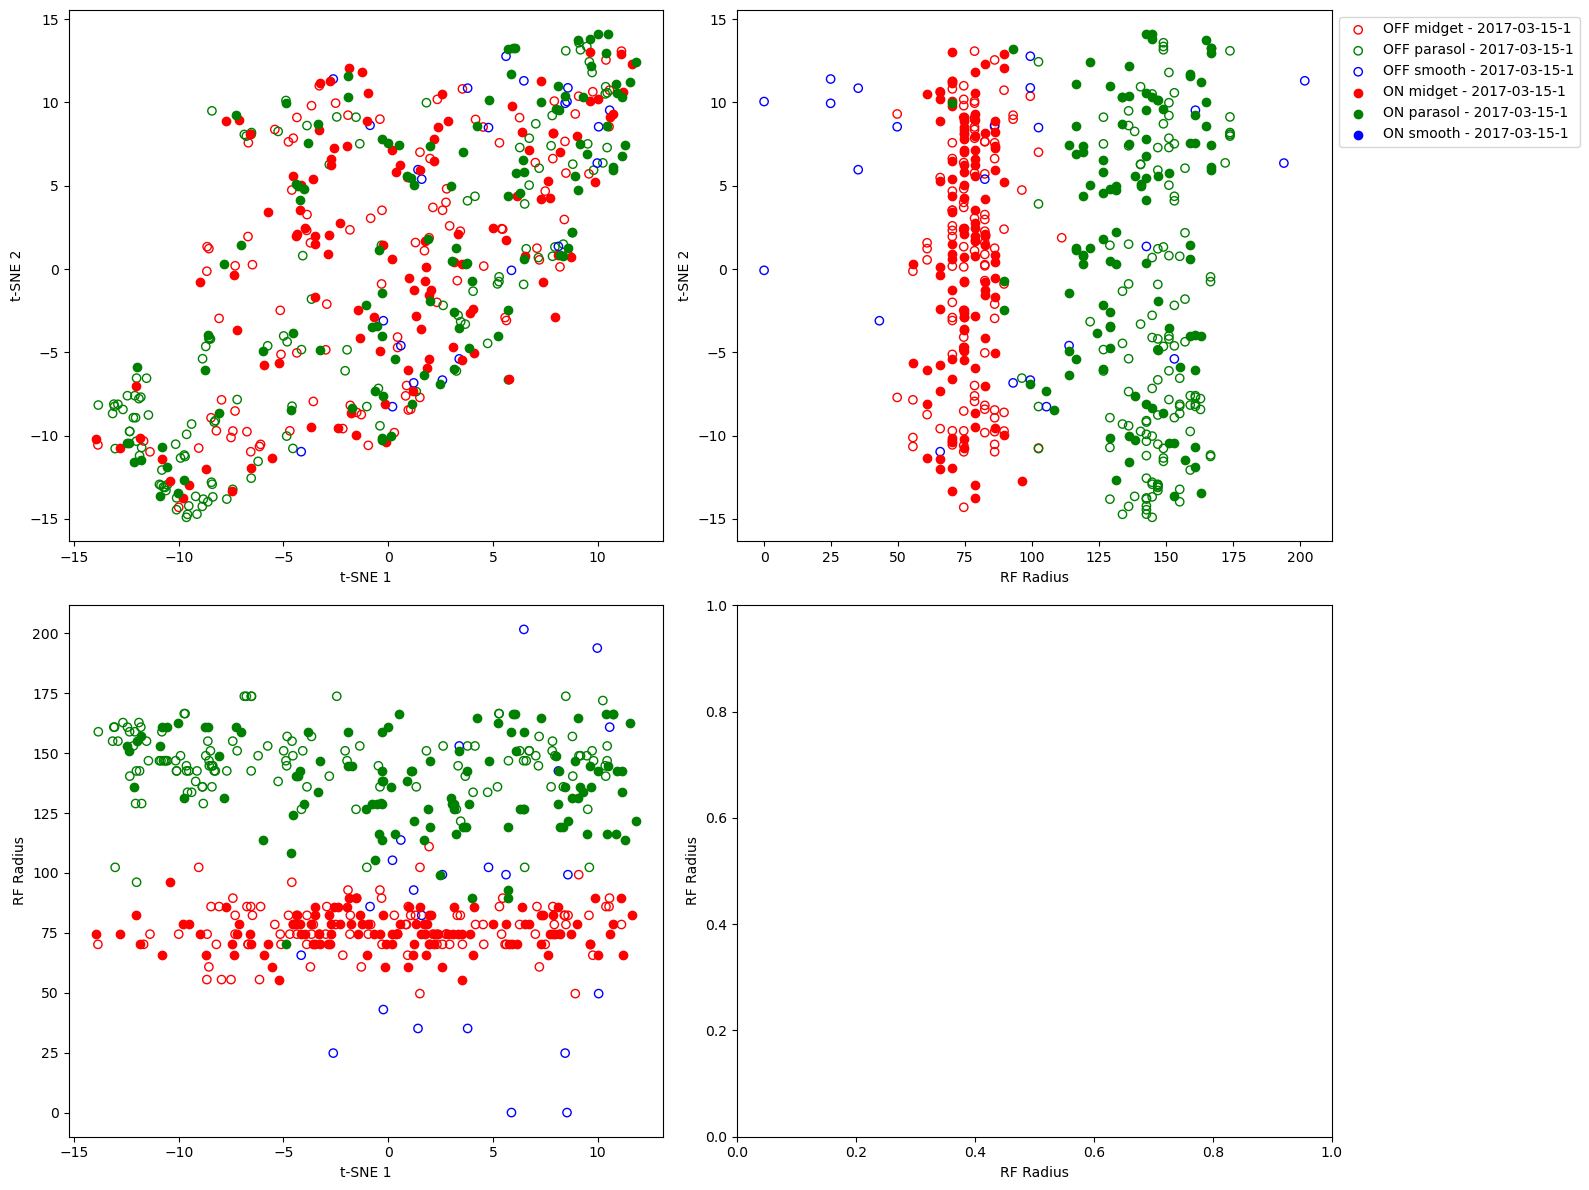

In [25]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

dataset = pieces[0]
piece_indices = [i for i, x in enumerate(piece_ids) if x == dataset]

pca = PCA(n_components=50)  # Adjust n_components based on your needs
pca_result = pca.fit_transform(normalized_tcs[piece_indices])

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result)

colors = {
    'ON parasol': 'green',
    'ON midget': 'red',
    'ON smooth': 'blue',
    'OFF parasol': 'green',
    'OFF midget': 'red',
    'OFF smooth': 'blue',
}
markers = ['o', 's']
fig, axs = plt.subplots(2,2,figsize=(16,12))
for cell_type in np.unique(all_cell_types):
    label = f"{cell_type} - {dataset}"
    indices = [i for i, x in enumerate(all_cell_types[piece_indices]) if x == cell_type]
    if 'ON' in cell_type:
        axs[0,0].scatter(tsne_results[indices,0], tsne_results[indices,1], label=label, c=colors[cell_type])
        axs[1,0].scatter(tsne_results[indices,0], all_cell_sizes[indices], label=label, c=colors[cell_type])
        axs[0,1].scatter(all_cell_sizes[indices], tsne_results[indices,1], label=label, c=colors[cell_type])
    else:
        axs[0,0].scatter(tsne_results[indices,0], tsne_results[indices,1], label=label, edgecolors=colors[cell_type],facecolors='none')
        axs[1,0].scatter(tsne_results[indices,0], all_cell_sizes[indices], label=label, edgecolors=colors[cell_type],facecolors='none')
        axs[0,1].scatter(all_cell_sizes[indices], tsne_results[indices,1], label=label, edgecolors=colors[cell_type],facecolors='none')
axs[0,0].set_xlabel("t-SNE 1")
axs[0,0].set_ylabel("t-SNE 2")

axs[1,0].set_xlabel("t-SNE 1")
axs[1,0].set_ylabel("RF Radius")

axs[0,1].set_ylabel("t-SNE 2")
axs[0,1].set_xlabel("RF Radius")

axs[1,1].set_xlabel("RF Radius")
axs[1,1].set_ylabel("RF Radius")

axs[0,1].legend(loc='upper left', bbox_to_anchor=(1, 1))


# Adjust the layout so the legend doesn't cut off
plt.tight_layout()
plt.show()


In [119]:
indices

array([487, 488, 491, 492, 493, 501, 507, 510, 511, 514, 515, 524, 526,
       527, 529, 532, 534, 542, 546, 548, 551, 553, 554, 557, 558, 563,
       564, 565, 567, 568, 570, 571, 574, 575, 584, 585, 586, 592, 593,
       596, 597, 598, 600, 604, 609, 610, 611, 612, 614, 615, 616, 620,
       625, 629, 631, 633, 638, 641, 645, 648, 656, 657, 662, 665, 666,
       667, 671, 672, 674, 677, 679, 686, 690, 691, 696, 703, 705, 707,
       708, 714, 715, 717, 720, 724, 728, 735, 738, 739, 742, 746, 747,
       751, 752, 758, 760, 764, 773, 782, 783, 787, 795, 799, 801, 802,
       808, 809, 817, 824, 830, 834, 838, 841, 842, 851, 859, 860, 864,
       865, 867, 870, 873, 874, 879, 884, 885, 886, 887, 889, 890, 892,
       899, 900, 906, 907, 908, 909, 910, 912, 914, 923, 924])